# Biodiversity Intactness Index change in Phoenix, AZ

**[Repository](https://github.com/richardmonteslemus/maricopa_bii)**

**Author: [Richard Montes Lemus](https://richardmonteslemus.github.io/)**

# About

## Purpose

Maricopa County contains the Phoenix metropolitan area and is the U.S. county with the most significant increase in developed land since 2001 (Levitt & Eng, 2021). This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems.

This analysis will use Biodiversity Intactness Index (BII) to measure and visualize the impact of this urban expansion on ecosytems(Gassert et al., 2022). It will examine changes in BII in the Phoenix county subdivision area between 2017 and 2020, shedding light on how urban growth affects biodiversity over time.

### Highlights


### Data: 
**Biodiversity Intactness Index (BII) Time Series:** This BII time series can be obtained through the [Microsoft Planetary Computer STAC Catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). It contains a 2017 and 2020 raster covering the Phoenix subdivision. It is read in as `phx_bii`. 

**Phoenix Subdivision Shapefile:** This shapefile polygon can be obtained through [TIGER Shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php). It contains Census County Subdivisions for Arizona. It is read in as `az_county`.

| References |
|---------------------|
| Gassert, F., Mazzarello, J., & Hyde, S. (2022, August). Global 100m projections of biodiversity intactness for the years 2017-2020 [Technical whitepaper]. https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf |
 Impact Observatory. (2022). 10m annual land use land cover (9-class) [Data set]. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02 |
| Levitt, Z., & Eng, J. (2021, August). Where America's developed areas are growing: 'Way off into the horizon'. The Washington Post. https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/ |
U.S. Census Bureau. (2023). TIGER/Line shapefiles: Arizona county subdivisions [Data set]. https://www2.census.gov/geo/tiger/TIGER2023/COUSUB/tl_2023_04_cousub.zip|



In [4]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
from shapely import box
from shapely.geometry import Polygon
import planetary_computer
from pystac_client import Client
from IPython.display import Image 
import contextily as ctx

### Load in Arizona County Shapefile Polygons 

In [ ]:
# Load in arizona county polygons
fp = os.path.join("data", "tl_2024_04_cousub", "tl_2024_04_cousub.shp")
az_county = gpd.read_file(fp)

# Clean columns
az_county.columns = az_county.columns.str.lower()

### Explore Arizona County Shapefile

In [9]:
# Print first few rows of dataframe 
az_county.head()

,statefp,countyfp,cousubfp,cousubns,geoid,geoidfq,name,namelsad,lsad,classfp,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [ ]:
# Check `az_county` crs
print(az_county.crs)

EPSG:4269


**Exploration Summary**
The arizona county shapfile data contains sub-county division per row along with its geometry. We obtained this information form using the head() function to print the first few rows of our dataset. We also used the `.crs` attribute to discover its crs is EPSG: 4269 a datum for North America. 

### Extract Phoenix sub-county division from `az_county`

In [20]:
# Return Phoenix polygon
phx = az_county[az_county.name == "Phoenix"]

# Check if Phoenix was successfully extracted
print(phx.name)

10    Phoenix
Name: name, dtype: object


<Axes: >

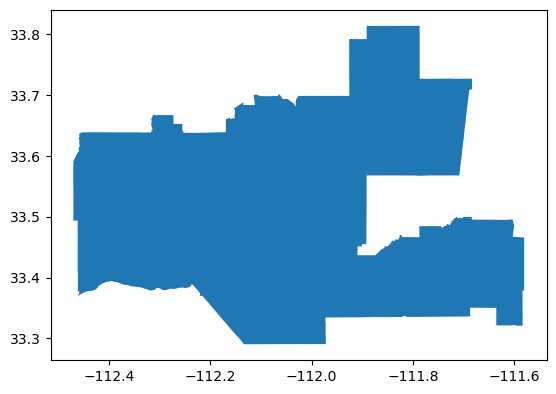

In [ ]:
# Plot Phoenix Area
phx.plot()

### Access Biodiversity Intactness Impact Data

In [21]:
# Access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Bound data to phoenix area
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Set date range 
dates = "2017-01-01/2021-01-01"

# Obtain BII data collection
search = catalog.search(collections=["io-biodiversity"],
                        bbox=bbox,
                        datetime=dates)
items = search.item_collection()

### Explore Biodiversity Intactness Impact Data

In [32]:
# Ensure items has expected length of 4 objects corresponding to dates
print(len(items))

4


In [ ]:
# Further explore collection information
items

In [ ]:
# Read in BII data as DataArrays for 2017 and 2020
bii_2017 = rioxr.open_rasterio(items[3].assets["data"].href)
bii_2020 = rioxr.open_rasterio(items[0].assets["data"].href)

In [33]:
# Explore CRS of DataArrays
print(bii_2017.rio.crs)
print(bii_2017.rio.crs)

EPSG:4326
EPSG:4326


**Exploration Summary:** The collection contains raster files for the defined bounding box corresponding to the Phoenix area. Item 0 contains data for 2020 and item 3 contains data for 2017. The BII DataArray was found to have a crs of EPSG:4326
